In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import sys
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [3]:
dataset_path = './data/wikiart_sample/'
dataset = ImageFolder(root=dataset_path, transform=transform)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.drop = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(512, 27)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [7]:
# Model Initialization
model = AdvancedCNN()
model.to(device)  # Move model to device

AdvancedCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [9]:
# # Training Loop
# for epoch in range(6):  # Loop over the dataset multiple times
#     for i, (inputs, labels) in enumerate(train_loader, 0):
#       inputs, labels = inputs.to(device), labels.to(device)
#       outputs = model(inputs)
#       loss = criterion(outputs, labels)
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#         # print(f"[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")
#       sys.stdout.write(f"\r[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")

#     # Validation
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#           inputs, labels = inputs.to(device), labels.to(device)
#           outputs = model(inputs)
#           _, predicted = torch.max(outputs.data, 1)
#           total += labels.size(0)
#           correct += (predicted == labels).sum().item()

#     # print(f'Validation accuracy after epoch {epoch+1}: {100 * correct / total}%')
#     sys.stdout.write(f'\rValidation accuracy after epoch {epoch+1}: {100 * correct / total}%')
#     sys.stdout.flush()

Validation accuracy after epoch 6: 6.406406406406407%

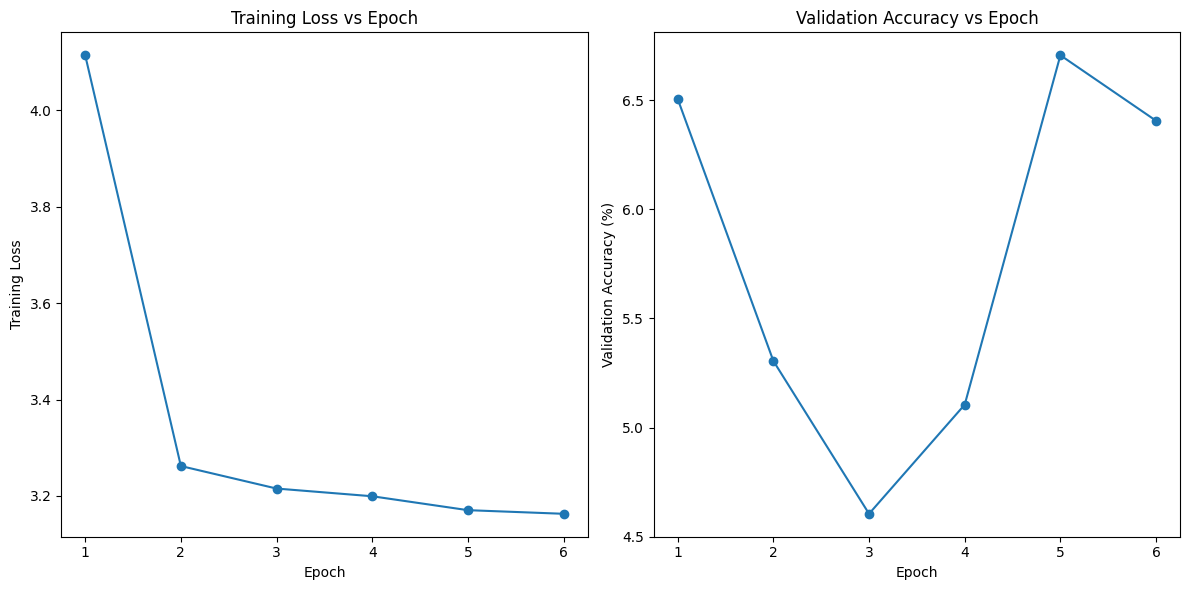

In [10]:
# Initialize lists to store loss and accuracy values
train_loss_values = []
val_accuracy_values = []

# Training Loop
for epoch in range(6):  # Loop over the dataset multiple times
    epoch_loss = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        sys.stdout.write(f"\r[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")

    scheduler.step()
    epoch_loss /= len(train_loader)
    train_loss_values.append(epoch_loss)

    # Validation
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracy_values.append(val_accuracy)
    sys.stdout.write(f'\rValidation accuracy after epoch {epoch+1}: {val_accuracy}%')
    sys.stdout.flush()

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, marker='o')
plt.title('Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')

plt.tight_layout()
plt.show()

In [11]:
torch.save(model, "wiki_advanced_model.pth")

In [12]:
# Calculate the most frequent label in the training set
label_counts = Counter([label for _, label in train_dataset])
most_common_label, frequency = label_counts.most_common(1)[0]

# Calculate the expected accuracy if no model (always predicting the most frequent label)
baseline_accuracy = (frequency / len(train_dataset)) * 100
print(f"Expected accuracy if no model: {baseline_accuracy:.2f}%")

Expected accuracy if no model: 4.38%


In [13]:
actual_accuracy = 100 * correct / total
print(f'Validation accuracy after training: {actual_accuracy:.2f}%')

Validation accuracy after training: 6.41%


In [14]:
label_to_style = {
    0: 'Abstract',
    1: 'Baroque',
    2: 'Cubism',
    3: 'Expressionism',
    4: 'Fauvism',
    5: 'Impressionism',
    6: 'Pop Art',
    7: 'Realism',
    8: 'Renaissance',
    9: 'Romanticism',
    10: 'Surrealism',
    11: 'Symbolism',
    12: 'Art Nouveau',
    13: 'Art Deco',
    14: 'Gothic',
    15: 'Neoclassicism',
    16: 'Post-Impressionism',
    17: 'Minimalism',
    18: 'Rococo',
    19: 'Byzantine',
    20: 'Contemporary',
    21: 'Photorealism',
    22: 'Pointillism',
    23: 'Futurism',
    24: 'Suprematism',
    25: 'Constructivism',
    26: 'Naive Art'
}

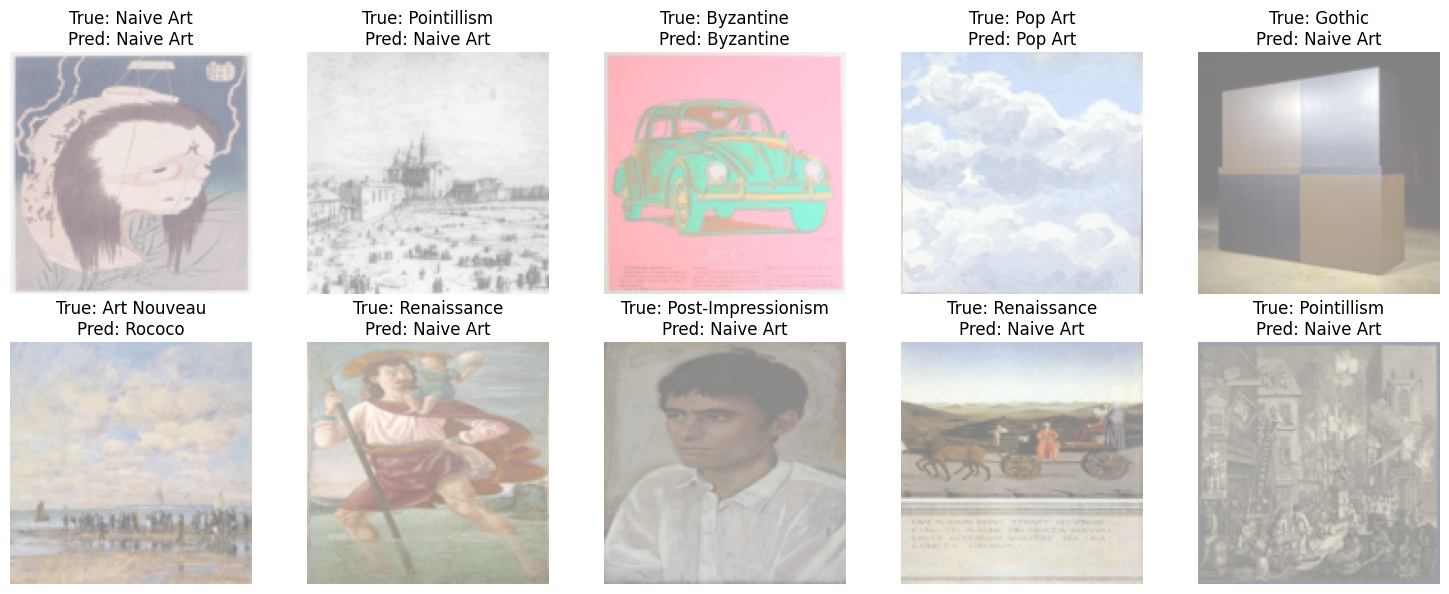

In [15]:
def imshow(img):
    img = img.cpu() / 2 + 0.5  # unnormalize and move to CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Move the iterator and model to the same device (assuming model is on GPU)
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to('cuda'), labels.to('cuda')

# Get the model output
outputs = model(images[:10])
_, predicted = torch.max(outputs.data, 1)

# Move images and labels back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Show images with true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjusted for a 2x5 grid

for i in range(10):  # Loop 10 times for 10 images
    row = i // 5
    col = i % 5
    img = images[i] / 2 + 0.5  # unnormalize
    img = img.numpy()
    axs[row, col].imshow(np.transpose(img, (1, 2, 0)))

    true_label = label_to_style[int(labels[i].item())]  # Make sure label_to_style is defined
    predicted_label = label_to_style[int(predicted[i].item())]

    axs[row, col].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [16]:
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model (assuming it's on GPU)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Move labels and predicted back to CPU for further processing
        labels = labels.cpu()
        predicted = predicted.cpu()

        all_labels.extend(labels)
        all_preds.extend(predicted)

# Convert to Python integers
all_labels = [label.item() for label in all_labels]
all_preds = [pred.item() for pred in all_preds]

# Calculate the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

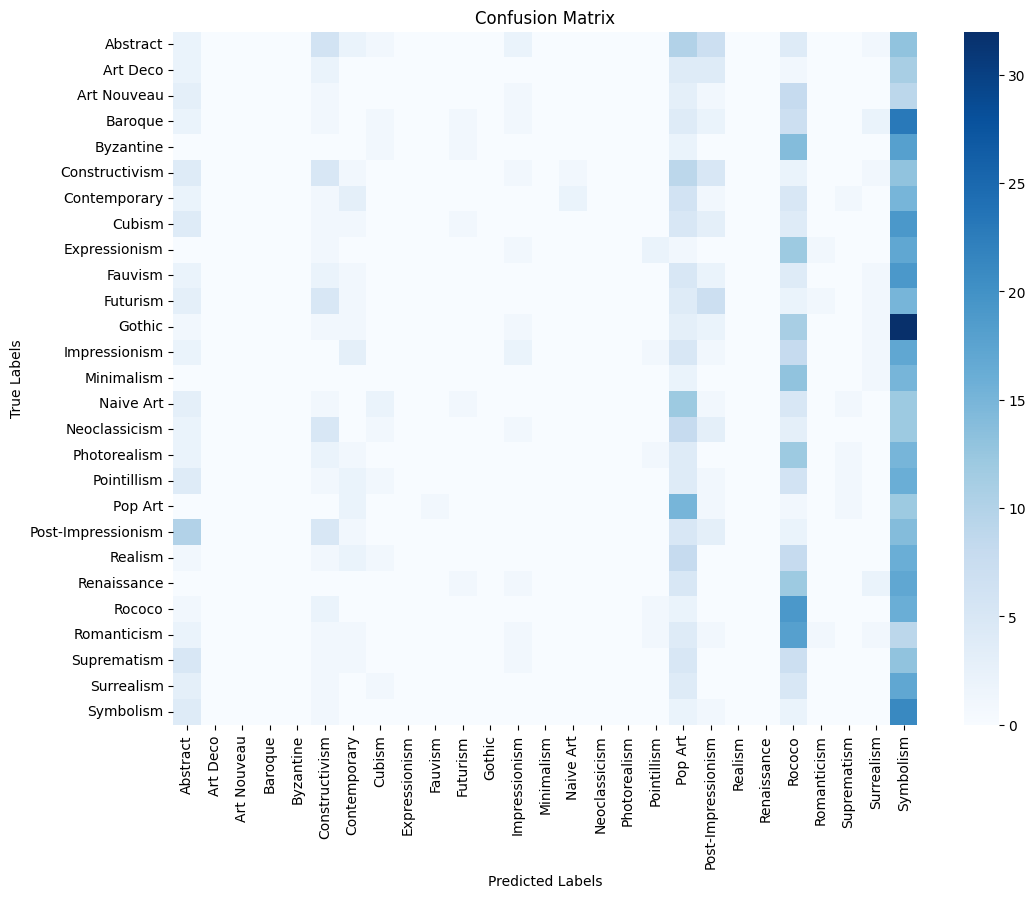

In [17]:
unique_styles = sorted(list(label_to_style.values()))

plt.figure(figsize=(12, 9))
sns.heatmap(conf_mat, fmt='d', cmap='Blues',
            xticklabels=unique_styles,
            yticklabels=unique_styles)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()